In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_coatnet_model(model_type='0', num_classes=4, pretrained=True):
    """
    Create CoAtNet (Convolution and Attention Network) model
    
    Args:
        model_type (str): Model variant - '0', '1', '2', '3', '4'
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: CoAtNet model
    """
    
    model = timm.create_model(f'coatnet_{model_type}_rw_224.sw_in1k', pretrained=pretrained, num_classes=num_classes)
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train CoAtNet-0

Training CoAtNet-0


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.65it/s, Loss=1.4824, Acc=0.3010]


Train Loss: 1.4824 Acc: 0.3010 Macro-F1: 0.2824


Val : 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=1.4946, Acc=0.3553]


Val Loss: 1.4946 Acc: 0.3553 Macro-F1: 0.2115
✓ New best model saved with validation macro-F1: 0.2115

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=1.1574, Acc=0.4934]


Train Loss: 1.1574 Acc: 0.4934 Macro-F1: 0.4471


Val : 100%|██████████| 10/10 [00:01<00:00,  7.30it/s, Loss=4.0349, Acc=0.3092]


Val Loss: 4.0349 Acc: 0.3092 Macro-F1: 0.1612

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=1.1419, Acc=0.5535]


Train Loss: 1.1419 Acc: 0.5535 Macro-F1: 0.4870


Val : 100%|██████████| 10/10 [00:01<00:00,  7.23it/s, Loss=1.0635, Acc=0.5395]


Val Loss: 1.0635 Acc: 0.5395 Macro-F1: 0.4406
✓ New best model saved with validation macro-F1: 0.4406

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=1.0364, Acc=0.5362]


Train Loss: 1.0364 Acc: 0.5362 Macro-F1: 0.4922


Val : 100%|██████████| 10/10 [00:01<00:00,  7.35it/s, Loss=1.0265, Acc=0.5066]


Val Loss: 1.0265 Acc: 0.5066 Macro-F1: 0.4207

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.8814, Acc=0.6595]


Train Loss: 0.8814 Acc: 0.6595 Macro-F1: 0.5986


Val : 100%|██████████| 10/10 [00:01<00:00,  7.27it/s, Loss=1.2712, Acc=0.4309]


Val Loss: 1.2712 Acc: 0.4309 Macro-F1: 0.3905

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.8146, Acc=0.6974]


Train Loss: 0.8146 Acc: 0.6974 Macro-F1: 0.6337


Val : 100%|██████████| 10/10 [00:01<00:00,  7.34it/s, Loss=2.0807, Acc=0.3980]


Val Loss: 2.0807 Acc: 0.3980 Macro-F1: 0.1839

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.7933, Acc=0.6801]


Train Loss: 0.7933 Acc: 0.6801 Macro-F1: 0.6248


Val : 100%|██████████| 10/10 [00:01<00:00,  7.12it/s, Loss=1.6057, Acc=0.5329]


Val Loss: 1.6057 Acc: 0.5329 Macro-F1: 0.4548
✓ New best model saved with validation macro-F1: 0.4548

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.5892, Acc=0.7862]


Train Loss: 0.5892 Acc: 0.7862 Macro-F1: 0.7481


Val : 100%|██████████| 10/10 [00:01<00:00,  7.14it/s, Loss=0.5160, Acc=0.7895]


Val Loss: 0.5160 Acc: 0.7895 Macro-F1: 0.7595
✓ New best model saved with validation macro-F1: 0.7595

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.5096, Acc=0.8273]


Train Loss: 0.5096 Acc: 0.8273 Macro-F1: 0.7893


Val : 100%|██████████| 10/10 [00:01<00:00,  7.26it/s, Loss=0.4497, Acc=0.8289]


Val Loss: 0.4497 Acc: 0.8289 Macro-F1: 0.8112
✓ New best model saved with validation macro-F1: 0.8112

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.95it/s, Loss=0.4487, Acc=0.8347]


Train Loss: 0.4487 Acc: 0.8347 Macro-F1: 0.8112


Val : 100%|██████████| 10/10 [00:01<00:00,  7.29it/s, Loss=0.5614, Acc=0.8092]


Val Loss: 0.5614 Acc: 0.8092 Macro-F1: 0.7875

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.4462, Acc=0.8355]


Train Loss: 0.4462 Acc: 0.8355 Macro-F1: 0.8130


Val : 100%|██████████| 10/10 [00:01<00:00,  7.30it/s, Loss=0.5256, Acc=0.8092]


Val Loss: 0.5256 Acc: 0.8092 Macro-F1: 0.7781

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.3619, Acc=0.8627]


Train Loss: 0.3619 Acc: 0.8627 Macro-F1: 0.8540


Val : 100%|██████████| 10/10 [00:01<00:00,  7.30it/s, Loss=0.6997, Acc=0.7599]


Val Loss: 0.6997 Acc: 0.7599 Macro-F1: 0.7281

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.3714, Acc=0.8660]


Train Loss: 0.3714 Acc: 0.8660 Macro-F1: 0.8598


Val : 100%|██████████| 10/10 [00:01<00:00,  7.35it/s, Loss=0.3520, Acc=0.8651]


Val Loss: 0.3520 Acc: 0.8651 Macro-F1: 0.8630
✓ New best model saved with validation macro-F1: 0.8630

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.3337, Acc=0.8799]


Train Loss: 0.3337 Acc: 0.8799 Macro-F1: 0.8680


Val : 100%|██████████| 10/10 [00:01<00:00,  6.93it/s, Loss=0.3490, Acc=0.8651]


Val Loss: 0.3490 Acc: 0.8651 Macro-F1: 0.8545

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.2871, Acc=0.8906]


Train Loss: 0.2871 Acc: 0.8906 Macro-F1: 0.8843


Val : 100%|██████████| 10/10 [00:01<00:00,  7.21it/s, Loss=0.3242, Acc=0.8684]


Val Loss: 0.3242 Acc: 0.8684 Macro-F1: 0.8553

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.2907, Acc=0.8964]


Train Loss: 0.2907 Acc: 0.8964 Macro-F1: 0.8865


Val : 100%|██████████| 10/10 [00:01<00:00,  7.28it/s, Loss=0.3131, Acc=0.8717]


Val Loss: 0.3131 Acc: 0.8717 Macro-F1: 0.8634
✓ New best model saved with validation macro-F1: 0.8634

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.95it/s, Loss=0.2744, Acc=0.8931]


Train Loss: 0.2744 Acc: 0.8931 Macro-F1: 0.8855


Val : 100%|██████████| 10/10 [00:01<00:00,  7.21it/s, Loss=0.3117, Acc=0.8684]


Val Loss: 0.3117 Acc: 0.8684 Macro-F1: 0.8635
✓ New best model saved with validation macro-F1: 0.8635

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.2823, Acc=0.9005]


Train Loss: 0.2823 Acc: 0.9005 Macro-F1: 0.8903


Val : 100%|██████████| 10/10 [00:01<00:00,  7.29it/s, Loss=0.3117, Acc=0.8849]


Val Loss: 0.3117 Acc: 0.8849 Macro-F1: 0.8716
✓ New best model saved with validation macro-F1: 0.8716

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.2664, Acc=0.9030]


Train Loss: 0.2664 Acc: 0.9030 Macro-F1: 0.8981


Val : 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=0.3023, Acc=0.8849]


Val Loss: 0.3023 Acc: 0.8849 Macro-F1: 0.8778
✓ New best model saved with validation macro-F1: 0.8778

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.2670, Acc=0.9030]


Train Loss: 0.2670 Acc: 0.9030 Macro-F1: 0.9041


Val : 100%|██████████| 10/10 [00:01<00:00,  7.31it/s, Loss=0.2878, Acc=0.8914]


Val Loss: 0.2878 Acc: 0.8914 Macro-F1: 0.8935
✓ New best model saved with validation macro-F1: 0.8935

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.2605, Acc=0.8980]


Train Loss: 0.2605 Acc: 0.8980 Macro-F1: 0.8909


Val : 100%|██████████| 10/10 [00:01<00:00,  7.18it/s, Loss=0.2856, Acc=0.8914]


Val Loss: 0.2856 Acc: 0.8914 Macro-F1: 0.8935

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.2435, Acc=0.9087]


Train Loss: 0.2435 Acc: 0.9087 Macro-F1: 0.9053


Val : 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=0.2893, Acc=0.8914]


Val Loss: 0.2893 Acc: 0.8914 Macro-F1: 0.8863

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.2745, Acc=0.9054]


Train Loss: 0.2745 Acc: 0.9054 Macro-F1: 0.9024


Val : 100%|██████████| 10/10 [00:01<00:00,  7.32it/s, Loss=0.2849, Acc=0.8914]


Val Loss: 0.2849 Acc: 0.8914 Macro-F1: 0.8832

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.97it/s, Loss=0.2536, Acc=0.9038]


Train Loss: 0.2536 Acc: 0.9038 Macro-F1: 0.8987


Val : 100%|██████████| 10/10 [00:01<00:00,  7.23it/s, Loss=0.2896, Acc=0.8914]


Val Loss: 0.2896 Acc: 0.8914 Macro-F1: 0.8830

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  2.96it/s, Loss=0.2480, Acc=0.9095]


Train Loss: 0.2480 Acc: 0.9095 Macro-F1: 0.9068


Val : 100%|██████████| 10/10 [00:01<00:00,  7.36it/s, Loss=0.2974, Acc=0.8882]


Val Loss: 0.2974 Acc: 0.8882 Macro-F1: 0.8773
Early stopping triggered after 25 epochs
Training complete in 6m 0s
Best validation macro-F1: 0.8935


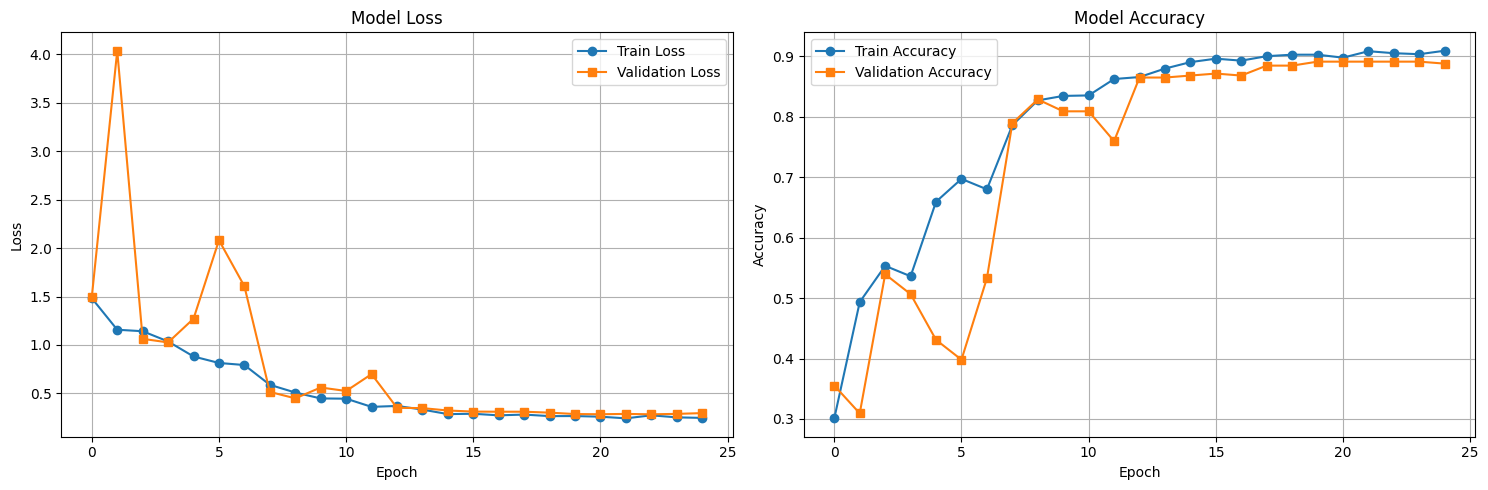

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


Test Accuracy: 49.21%
Test Loss: 2.1654

Classification Report:
              precision    recall  f1-score   support

         HGC       0.84      0.77      0.80        74
         LGC       0.28      0.15      0.20        53
         NST       0.64      0.49      0.55        37
         NTL       0.16      0.40      0.22        25

    accuracy                           0.49       189
   macro avg       0.48      0.45      0.44       189
weighted avg       0.55      0.49      0.51       189


Confusion Matrix:
[[57  4  2 11]
 [11  8  4 30]
 [ 0  6 18 13]
 [ 0 11  4 10]]

ROC-AUC Scores:
Macro-average AUC: 0.6520
Micro-average AUC: 0.6766
HGC AUC: 0.8792
LGC AUC: 0.2816
NST AUC: 0.8839
NTL AUC: 0.5632


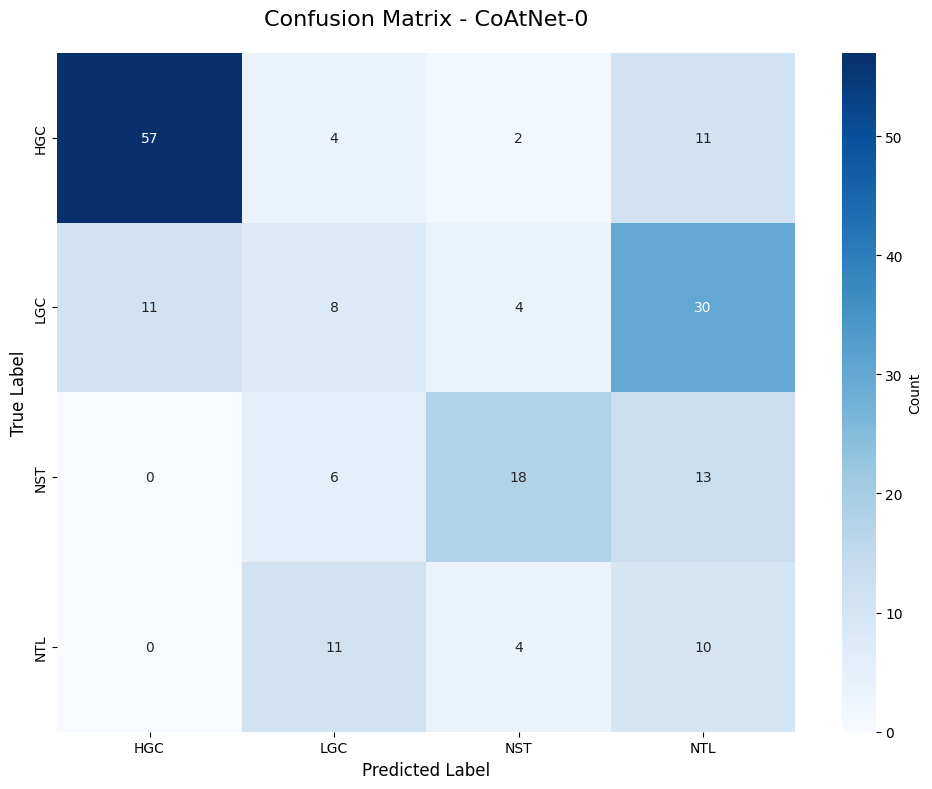

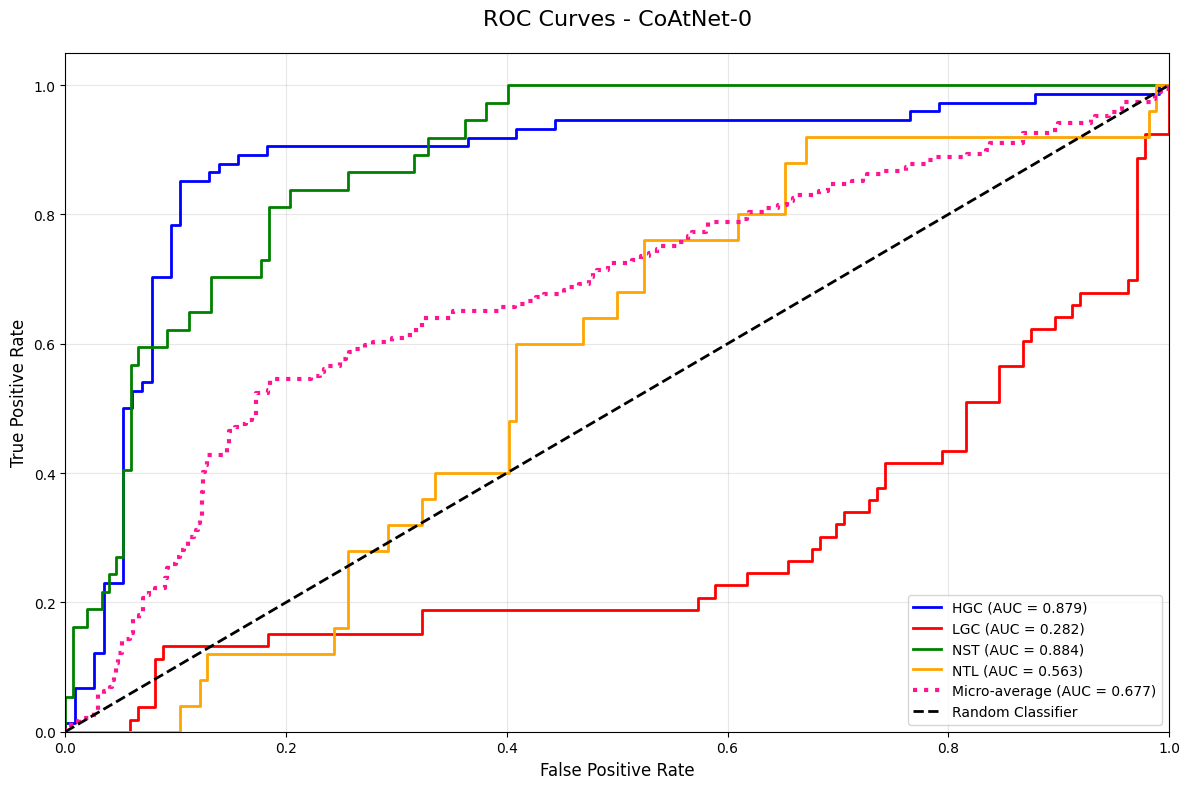


CoAtNet-0 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training CoAtNet-0")
print("=" * 80)

# Create model
coatnet_0 = create_coatnet_model(model_type='0', num_classes=4, pretrained=True)

# Create trainer
trainer_coatnet_0 = ModelTrainer(coatnet_0, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_coatnet_0 = trainer_coatnet_0.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="CoAtNet-0")

# Plot training history
trainer_coatnet_0.plot_training_history(save_path='coatnet_0_training_history.png')

# Evaluate model
results_coatnet_0 = trainer_coatnet_0.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_coatnet_0['confusion_matrix'], class_names, 'CoAtNet-0',
                      save_path='coatnet_0_confusion_matrix.png')

# Plot ROC curves
roc_auc_coatnet_0 = plot_roc_curves(results_coatnet_0['labels'], results_coatnet_0['probabilities'], class_names, 'CoAtNet-0',
                                     save_path='coatnet_0_roc_curves.png')

# Store results
results_coatnet_0['model_name'] = 'CoAtNet-0'
results_coatnet_0['roc_auc'] = roc_auc_coatnet_0
all_results.append(results_coatnet_0)

print("\nCoAtNet-0 training and evaluation complete!")

## Train CoAtNet-1

Training CoAtNet-1


model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.5181, Acc=0.3240]


Train Loss: 1.5181 Acc: 0.3240 Macro-F1: 0.2867


Val : 100%|██████████| 10/10 [00:02<00:00,  4.83it/s, Loss=1.6172, Acc=0.2763]


Val Loss: 1.6172 Acc: 0.2763 Macro-F1: 0.2200
✓ New best model saved with validation macro-F1: 0.2200

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.2239, Acc=0.4564]


Train Loss: 1.2239 Acc: 0.4564 Macro-F1: 0.4106


Val : 100%|██████████| 10/10 [00:02<00:00,  4.82it/s, Loss=1.5180, Acc=0.4737]


Val Loss: 1.5180 Acc: 0.4737 Macro-F1: 0.3701
✓ New best model saved with validation macro-F1: 0.3701

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.0522, Acc=0.5206]


Train Loss: 1.0522 Acc: 0.5206 Macro-F1: 0.4654


Val : 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=0.9087, Acc=0.5888]


Val Loss: 0.9087 Acc: 0.5888 Macro-F1: 0.5034
✓ New best model saved with validation macro-F1: 0.5034

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.0636, Acc=0.4901]


Train Loss: 1.0636 Acc: 0.4901 Macro-F1: 0.4421


Val : 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=2.1263, Acc=0.3717]


Val Loss: 2.1263 Acc: 0.3717 Macro-F1: 0.2658

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=1.0171, Acc=0.5321]


Train Loss: 1.0171 Acc: 0.5321 Macro-F1: 0.4791


Val : 100%|██████████| 10/10 [00:02<00:00,  4.78it/s, Loss=0.9480, Acc=0.4967]


Val Loss: 0.9480 Acc: 0.4967 Macro-F1: 0.4525

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=0.9592, Acc=0.5485]


Train Loss: 0.9592 Acc: 0.5485 Macro-F1: 0.4988


Val : 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=2.2319, Acc=0.3224]


Val Loss: 2.2319 Acc: 0.3224 Macro-F1: 0.2257

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=0.9074, Acc=0.5173]


Train Loss: 0.9074 Acc: 0.5173 Macro-F1: 0.4924


Val : 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=1.5867, Acc=0.4145]


Val Loss: 1.5867 Acc: 0.4145 Macro-F1: 0.2422

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=0.7900, Acc=0.6258]


Train Loss: 0.7900 Acc: 0.6258 Macro-F1: 0.5409


Val : 100%|██████████| 10/10 [00:02<00:00,  4.76it/s, Loss=1.2612, Acc=0.5197]


Val Loss: 1.2612 Acc: 0.5197 Macro-F1: 0.4222
Early stopping triggered after 8 epochs
Training complete in 3m 16s
Best validation macro-F1: 0.5034


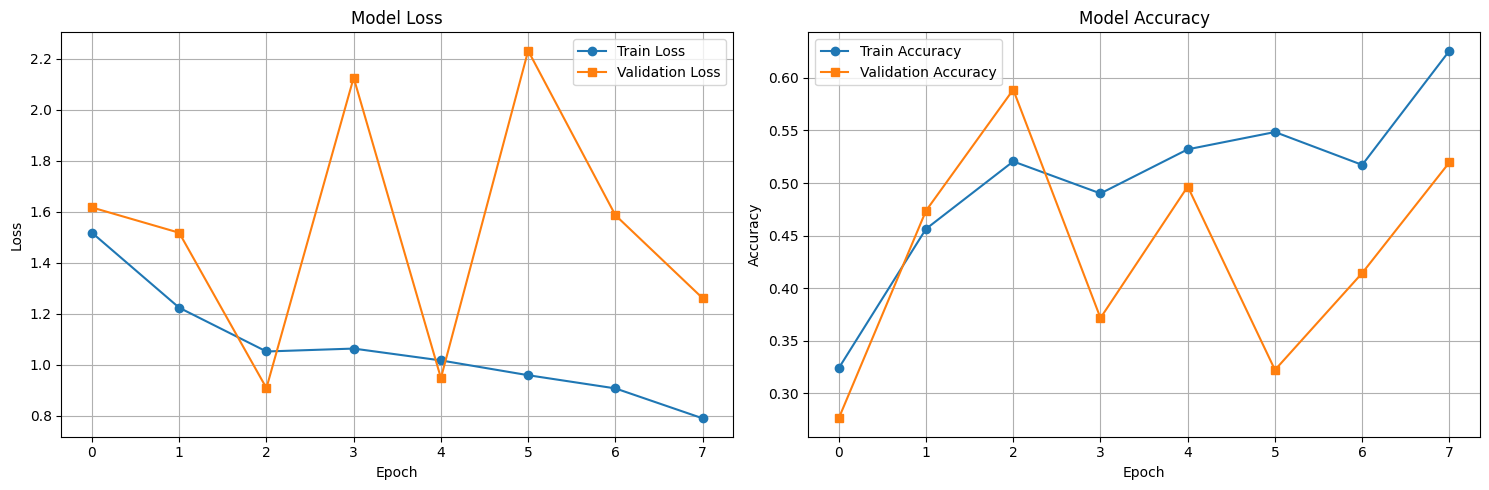

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


Test Accuracy: 56.08%
Test Loss: 1.6080

Classification Report:
              precision    recall  f1-score   support

         HGC       1.00      0.65      0.79        74
         LGC       0.41      0.87      0.56        53
         NST       0.56      0.27      0.36        37
         NTL       0.18      0.08      0.11        25

    accuracy                           0.56       189
   macro avg       0.54      0.47      0.45       189
weighted avg       0.64      0.56      0.55       189


Confusion Matrix:
[[48 21  4  1]
 [ 0 46  2  5]
 [ 0 24 10  3]
 [ 0 21  2  2]]

ROC-AUC Scores:
Macro-average AUC: 0.7034
Micro-average AUC: 0.7000
HGC AUC: 0.8731
LGC AUC: 0.5028
NST AUC: 0.7534
NTL AUC: 0.6844


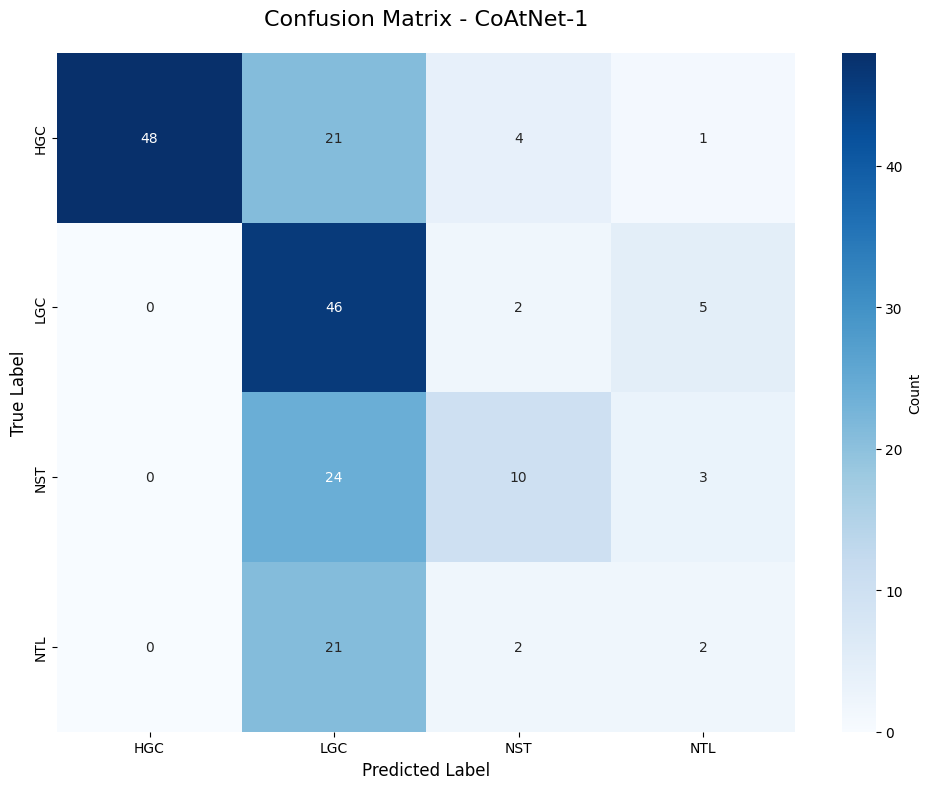

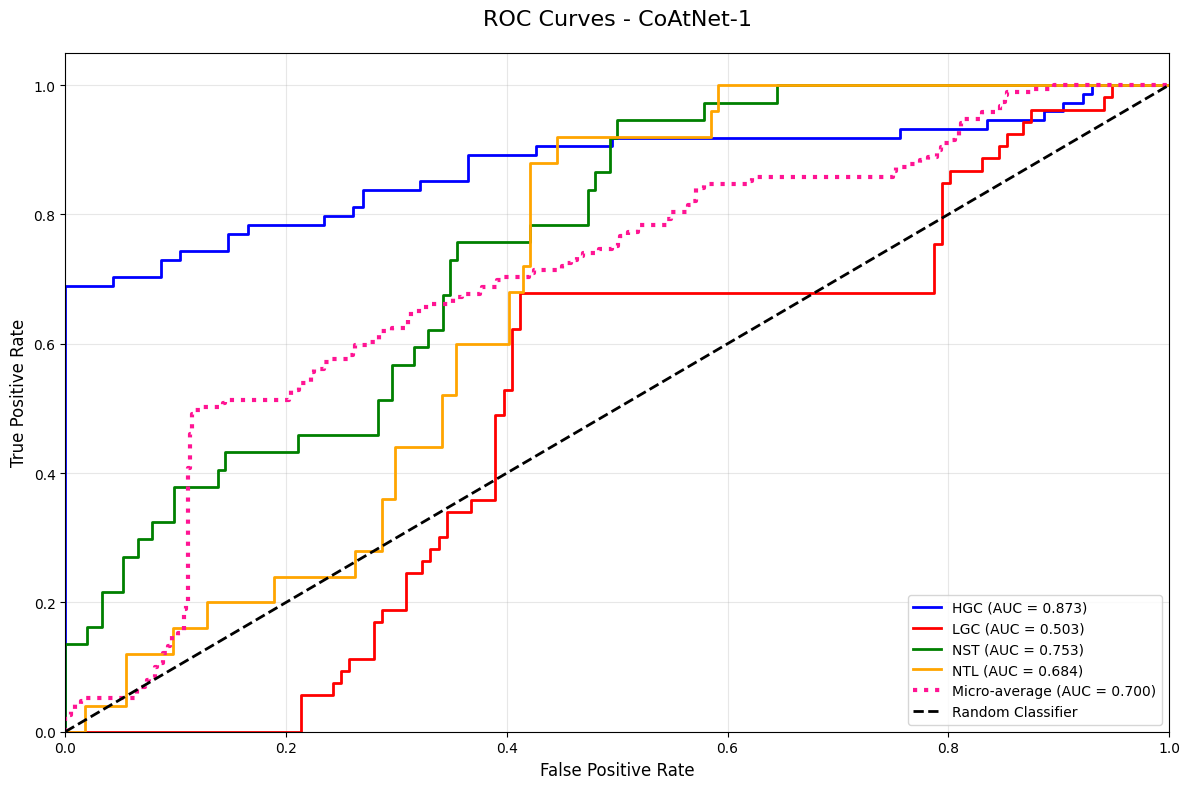


CoAtNet-1 training and evaluation complete!


In [17]:
print("=" * 80)
print("Training CoAtNet-1")
print("=" * 80)

# Create model
coatnet_1 = create_coatnet_model(model_type='1', num_classes=4, pretrained=True)

# Create trainer
trainer_coatnet_1 = ModelTrainer(coatnet_1, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_coatnet_1 = trainer_coatnet_1.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="CoAtNet-1")

# Plot training history
trainer_coatnet_1.plot_training_history(save_path='coatnet_1_training_history.png')

# Evaluate model
results_coatnet_1 = trainer_coatnet_1.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_coatnet_1['confusion_matrix'], class_names, 'CoAtNet-1',
                      save_path='coatnet_1_confusion_matrix.png')

# Plot ROC curves
roc_auc_coatnet_1 = plot_roc_curves(results_coatnet_1['labels'], results_coatnet_1['probabilities'], class_names, 'CoAtNet-1',
                                     save_path='coatnet_1_roc_curves.png')

# Store results
results_coatnet_1['model_name'] = 'CoAtNet-1'
results_coatnet_1['roc_auc'] = roc_auc_coatnet_1
all_results.append(results_coatnet_1)

print("\nCoAtNet-1 training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'CoAtNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: CoAtNet_metrics.csv

Metrics Summary:
       Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  CoAtNet-0         49.206349      2.165376             0.478301          0.451925      0.444126                0.552074             0.492063         0.507197       0.838235    0.770270  0.802817         74.0       0.275862    0.150943  0.195122         53.0       0.642857    0.486486  0.553846         37.0       0.156250        0.40  0.224719         25.0   0.651973   0.676642  0.879201  0.281632  0.883890  0.563171      0.879201      0.28